# This notebook is plotting the spatial distribution of the spectral parameters.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne

import warnings
warnings.filterwarnings('ignore')

from pingouin import ttest

from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

In [2]:
# Functions
def get_sorted_vals(df, channels, feature='', avg_type='median'):
    """gets values of specparam feature sorted by channels in MNE object
    
    Parameters
    ----------
    df: dataframe
        dataframe of all subjects & specparam features
    channels: list
        channels in MNE object in order, will be used to determine final order of values
    feature: str
        feature of interest, must match column in df
    avg_type: str
        method to get value of avg feature for each electrode across subject, mean or median
        
    Returns
    -------
    sorted_pre_features: 1d array
        values of desired parameter pre-treatment in the same order as MNE channels
    sorted_post_features: 1d array
        same but post
    sorted_diff_features: 1d array
        same but diff
    t_vals: 1d array
        t-statistics of desired parameter per chanel, pre- vs. post from paired ttest
    p_vals: 1d array
        p-statistics of desired parameter per chanel, pre- vs. post from paired ttest
        """
    # get difference dataframe
    diff_array = pd.DataFrame(df.groupby(['patient','channel'], sort=False, as_index=False)[feature].diff())
    diff_array[['patient','channel', 'pre_post']] = df[['patient','channel', 'pre_post']]
    diff_array_nonan = diff_array[diff_array['pre_post']=='post']
    
    # get t-value of pre-post difference
    t_vals = []
    p_vals = []

    if feature =='delta_amp' or feature=='theta_amp' or feature=='r_squared':
        t_vals = np.nan
        p_vals = np.nan
    else:
        for chan in channels:
            pre_vals = df[(df['channel']==chan) &
                                       (df['pre_post']=='pre')][feature].values
            post_vals = df[(df['channel']==chan) &
                                        (df['pre_post']=='post')][feature].values

        
            stats = ttest(pre_vals, post_vals, paired=True)
            t_vals.append(float(stats['T'].values))
            p_vals.append(float(stats['p-val'].values))
  
    
    # get values from dataframe
    if avg_type == 'mean':
        feature_array = pd.DataFrame(df.groupby(['pre_post', 'channel'], sort=False, as_index=False)[feature].mean())
        diff_features = pd.DataFrame(diff_array_nonan.groupby(['channel'], as_index=False)[feature].mean())
    elif avg_type == 'median':
        feature_array = pd.DataFrame(df.groupby(['pre_post', 'channel'], sort=False, as_index=False)[feature].median())
        diff_features = pd.DataFrame(diff_array_nonan.groupby(['channel'], sort=False, as_index=False)[feature].median())
    else:
        raise ValueError('avg_type must be mean or median')

    pre_features = feature_array[feature_array['pre_post']=='pre'][feature].values
    post_features = feature_array[feature_array['pre_post']=='post'][feature].values
    diff_features = diff_features[feature].values

    # get channels from dataframe and re-order to match MNE info object
    df_channels = list(feature_array[feature_array['pre_post']=='pre']['channel'].values)
    sorted_index = []

    for chan in df_channels:
        sorted_index.append(channels.index(chan))

    sorted_pre_features = np.array([pre_features[i] for i in sorted_index])
    sorted_post_features = np.array([post_features[i] for i in sorted_index])
    sorted_diff_features = np.array([diff_features[i] for i in sorted_index])
    
    return sorted_pre_features, sorted_post_features, sorted_diff_features, np.asarray(t_vals), np.asarray(p_vals)

## Load dataframe

In [5]:
exp_df = pd.read_csv('../saved_files/ect_files/ect_all_features.csv', index_col = 0)

# Exclude pre/post measurements with bad fits
exp_df_included = exp_df[exp_df['exclude']==False]

### Get MNE info object for electrode positions

In [7]:
eeg_data_path = # data path
eeg_data = mne.io.read_raw(eeg_data_path)
eeg_data = eeg_data.pick_types(eeg=True)
mne_chans = eeg_data.info['ch_names']

Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT002_POST_REST_EC.fif...
    Range : 0 ... 649199 =      0.000 ...   649.199 secs
Ready.


# Exponent

In [12]:
sorted_pre_exponents, sorted_post_exponents, diff, t_vals, p_vals = get_sorted_vals(exp_df_included, mne_chans,
                                                              feature='exponent', avg_type='median')

Text(0.5, 1.0, '$\\Delta$ exponent')

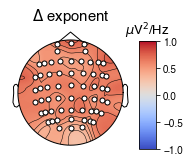

In [13]:
unit_label = '$\mu$V$^2$/Hz'
fig, ax = plt.subplots(1,1, figsize=[4,2])

mask = p_vals < 0.05
mask_params = dict(markersize=5, markerfacecolor="white")

im, cm = mne.viz.plot_topomap(diff, axes=ax, pos=eeg_data.info, show=False,
                              vmin=-1.0, vmax=1.0, cmap='coolwarm', mask=mask, mask_params=mask_params)

# Set the colorbar position 
ax_x_start = 0.75
ax_x_width = 0.06
ax_y_start = 0.1
ax_y_height = 0.75
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax.set_title('$\Delta$ exponent', fontsize=15)

# Delta Band Power

In [14]:
sorted_pre_delta_bp, sorted_post_delta_bp, diff, t_vals, p_vals  = get_sorted_vals(exp_df_included, mne_chans,
                                                             feature='delta_bp', avg_type='median')

Text(0.5, 1.0, '$\\Delta$ band power')

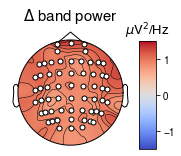

In [16]:
unit_label = '$\mu$V$^2$/Hz'

fig, ax = plt.subplots(1,1, figsize=[4,2])

mask = p_vals < 0.05
mask_params = dict(markersize=5, markerfacecolor="white")

im, cm = mne.viz.plot_topomap(diff, axes=ax, pos=eeg_data.info, show=False,
                              vmin=-1.5, vmax=1.5, cmap='coolwarm', mask=mask, mask_params=mask_params)

# Set the colorbar position 
ax_x_start = 0.75
ax_x_width = 0.06
ax_y_start = 0.1
ax_y_height = 0.75
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax.set_title('$\Delta$ band power', fontsize=15)

# Theta

In [17]:
sorted_pre_theta_amps, sorted_post_theta_amps, diff, t_vals, p_vals = get_sorted_vals(exp_df_included, mne_chans,
                                                                feature='theta_amp', avg_type='median')
    
sorted_pre_theta_amps = np.nan_to_num(sorted_pre_theta_amps, nan=0.05) # replace no theta peak channels with absolute threshold
sorted_post_theta_amps = np.nan_to_num(sorted_post_theta_amps, nan=0.05) # replace no theta peak channels with abs threshold
diff = np.nan_to_num(diff, nan=0.05)                                                                

Text(0.5, 1.0, '$\\Delta$ theta osc. power')

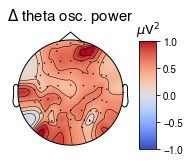

In [18]:
unit_label = '$\mu$V$^2$'
fig, ax = plt.subplots(1,1, figsize=[4,2])

im, cm = mne.viz.plot_topomap(diff, axes=ax, pos=eeg_data.info, show=False,
                              vmin=-1.0, vmax=1.0, cmap='coolwarm')

# Set the colorbar position 
ax_x_start = 0.75
ax_x_width = 0.06
ax_y_start = 0.1
ax_y_height = 0.75
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax.set_title('$\Delta$ theta osc. power', fontsize=15)

# Alpha

In [19]:
sorted_pre_alpha_amps, sorted_post_alpha_amps, diff, t_vals, p_vals = get_sorted_vals(exp_df_included, mne_chans,
                                                                feature='alpha_amp', avg_type='median')
    
sorted_pre_alpha_amps = np.nan_to_num(sorted_pre_alpha_amps, nan=0.05) # replace no alpha peak channels with absolute threshold
sorted_post_alpha_amps = np.nan_to_num(sorted_post_alpha_amps, nan=0.05) # replace no alpha peak channels with abs threshold
diff = np.nan_to_num(diff, nan=0.05)                                                                

Text(0.5, 1.0, '$\\Delta$ alpha osc. power')

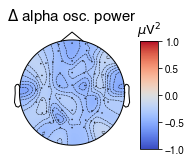

In [20]:
unit_label = '$\mu$V$^2$'
fig, ax = plt.subplots(1,1, figsize=[4,2])

im, cm = mne.viz.plot_topomap(diff, axes=ax, pos=eeg_data.info, show=False,
                              vmin=-1.0, vmax=1.0, cmap='coolwarm')

# Set the colorbar position 
ax_x_start = 0.75
ax_x_width = 0.06
ax_y_start = 0.1
ax_y_height = 0.75
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax.set_title('$\Delta$ alpha osc. power', fontsize=15)